# Sharks versus Dolphins
Binary Image Classifier with fast.ai and for Sharks versus Dolphins, using google image pictures.

## 1. Create a dataset
I used the python tool `google_images_download` to download about 500 images of dolphins and 500 images of sharks from google image search. Images are under creative commons licence for non-commercial reuse. I split the entire dataset into a training and a validation set, 80/20 split.

In [3]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# from google_images_download import google_images_download 

# os.chdir('/home/paperspace/data/sharksdolphins/')
# response = google_images_download.googleimagesdownload()  

# arguments = {
#   "keywords": '"shark","dolphin"',
#   "print_urls": False,
#   "limit": "10000",
#   "output_directory": "sharksdolphins",
#   "format": "jpg",
#   "usage_rights": "labeled-for-nocommercial-reuse",
#   "chromedriver": "/usr/local/bin/chromedriver"
# }

In [ ]:
# response.download(arguments) 

## 2. Split into Test and Validation Set

In [ ]:
%mkdir /home/paperspace/data/sharksdolphins/valid
%mkdir /home/paperspace/data/sharksdolphins/valid/shark
%mkdir /home/paperspace/data/sharksdolphins/valid/dolphin

In [2]:
# split files into test and training set
PATH = 'data/sharksdolphins/'
files_sharks = os.listdir(f'{PATH}train/shark')
files_dolphins = os.listdir(f'{PATH}train/dolphin')

# sample from each class to create a validation set
np.random.seed(1234)
files_sharks_val = np.random.choice(
    files_sharks, 
    size=round(len(files_sharks) / 5), 
    replace=False, 
    p=None)
files_dolphins_val = np.random.choice(
    files_dolphins, 
    size=round(len(files_dolphins) / 5), 
    replace=False, 
    p=None)

FileNotFoundError: [Errno 2] No such file or directory: 'data/sharksdolphins/train/shark'

In [ ]:
sink = [os.rename(PATH+'train/shark/'+file, PATH+'valid/shark/'+file) for file in files_sharks_val]
sink = [os.rename(PATH+'train/dolphin/'+file, PATH+'valid/dolphin/'+file) for file in files_dolphins_val]
# TODO: Add conditional to exclude non-jpg files

Turns out that fast.ai is somewhat sensitive to funky filenames, so I had to step back here and rename the files. I went with the index number, plus zero padding, removing the file name string.

In [ ]:
# func for renaming an image file
def image_rename(file):
    file_index = re.match(r'\A\d*', file).group(0)
    file_index = file_index.zfill(3)
    return file_index+'.jpg'

# func for renaming all files in a folder
def image_rename_all(folder):
    files = os.listdir(folder)
    [os.rename(folder+file, folder+image_rename(file)) for file in files]

folders = ['data/sharksdolphins/train/shark/',
           'data/sharksdolphins/train/dolphin/',
           'data/sharksdolphins/valid/shark/',
           'data/sharksdolphins/valid/dolphin/']

# rename files
[image_rename_all(folder) for folder in folders]

In [ ]:
img = plt.imread('/home/paperspace/data/sharksdolphins/train/shark/050.jpg')
plt.imshow(img);

### i. First Model
In a simple attempt with pretrained resnet 34, training only the last layer.

In [4]:
os.chdir('/home/paperspace/')
# append fast.ai local folder to system path so modules can be imported
sys.path.append('/home/paperspace/fastai/')
# automatically reload updated sub-modules
%reload_ext autoreload
%autoreload 2
# in-line plots
%matplotlib inline

In [5]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [6]:
# make sure these both return TRUE 
# (test of GPU availability)
torch.cuda.is_available()

True

In [7]:
# (test of CuDNN GPU acceleration)
torch.backends.cudnn.enabled

True

In [8]:
# set path of data folder
PATH = "data/sharksdolphins/"
# set size images should be resized to
sz = 224

In [9]:
# Uncomment the below if you need to reset your precomputed activations
shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [10]:
# First model
arch = resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz), bs = 16)
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


### Set the learning rate
Jeremy explained the learning rate finder that uses the approach of cyclical learning rates as outlined by Leslie Smith (https://arxiv.org/abs/1506.01186). Using the lr_find method and then plotting the learning rate against loss. We now want to visually choose the "The highest learning rate we can find where the loss is still clearly improving".

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 55%|█████▌    | 22/40 [00:00<00:00, 53.46it/s, loss=4.55] 


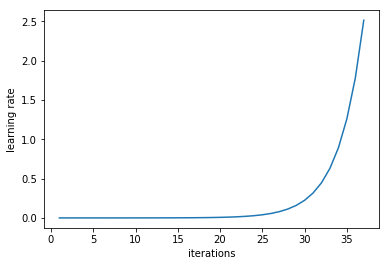

In [11]:
learn.lr_find()
learn.sched.plot_lr()

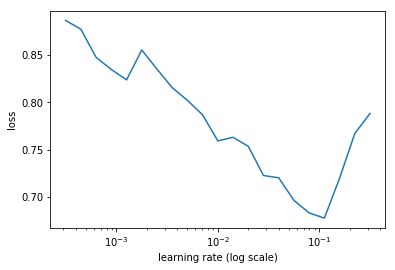

In [12]:
learn.sched.plot()

In [13]:
learn.fit(0.01, 5)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      0.435999   0.267501   0.925     
    1      0.3081     0.29459    0.9                        
    2      0.2548     0.235716   0.925                      
    3      0.214654   0.229093   0.93125                   
    4      0.237024   0.162347   0.9375                     



[array([0.16235]), 0.9375]

### Have a Look at Model Predictions

In [23]:
# def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)

# def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

def plot_problematics():
    plot_val_with_title(most_by_correct(0, False), "Most incorrect")
    plot_val_with_title(most_by_correct(1, False), "")

In [24]:
log_preds = learn.predict()
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:,1])

Most incorrect



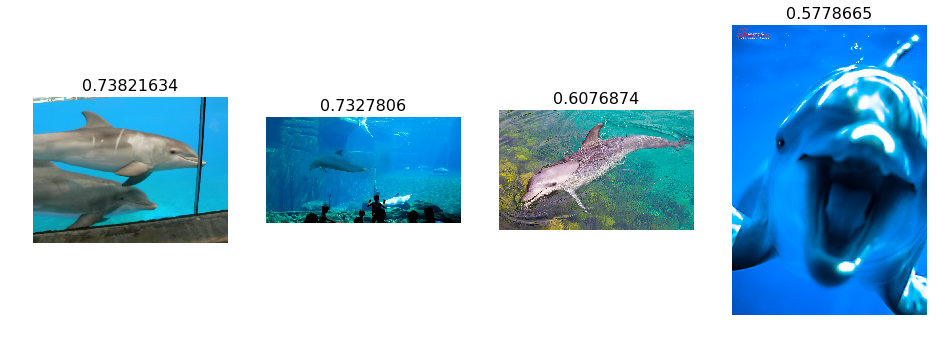

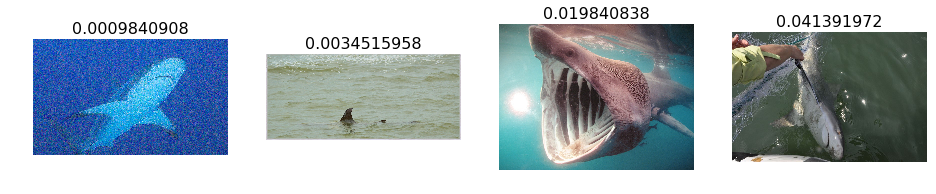

In [25]:
plot_problematics()

### ii. Second Model
Now let's start training some of the lower layers and retraining these with differential learning rate. Jeremy talks about unfreezing here, but a friend that I talked to about this called it thawing instead, and I like that terminology, as it implies the differential learning rates with fast-changing weights at the last layer but slower updates in the lower layers.

In [27]:
learn.unfreeze()
lr = np.array([1e-4,1e-3,1e-2])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

 57%|█████▊    | 23/40 [00:07<00:05,  3.02it/s, loss=0.526]


Exception in thread Thread-15:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                  
    0      0.475365   0.365881   0.89375   
    1      0.278049   0.177107   0.94375                   
    2      0.174708   0.178467   0.95                      
    3      0.120919   0.230777   0.95625                   
    4      0.093978   0.148054   0.95625                    
    5      0.081571   0.200582   0.95                       
    6      0.055903   0.198029   0.95                       



[array([0.19803]), 0.95]

Most incorrect



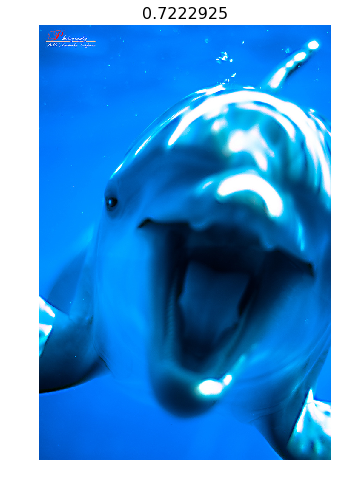

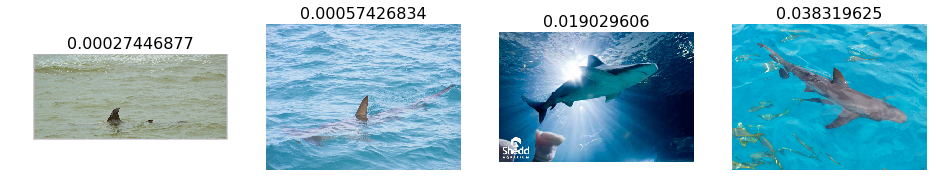

In [28]:
# plot misclassified
log_preds = learn.predict()
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:,1])
plot_problematics()

[[82  1]
 [ 7 70]]


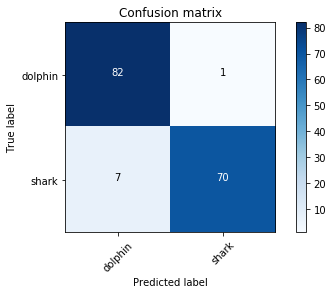

In [29]:
# confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(data.val_y, preds)
plot_confusion_matrix(cm, data.classes)

In [30]:
# save weights
learn.save('224_all_v2')

In [ ]:
learn.load('224_all_v2')